In [18]:
import torch
from torch import nn
from d2l import torch as d2l


In [19]:
n_train = 50
x_train, _ = torch.sort(torch.rand(n_train)*5)

def f(x):
    return 2*torch.sin(x)+x**0.8

y_train = f(x_train)+torch.normal(0.0, 0.5, (n_train,)) # 后面加个噪声
x_test = torch.arange(0,5,0.1) # 50个测试样本
y_truth = f(x_test)
n_test = len(x_test)
n_test

50

In [20]:
# 下面的函数将绘制所有的训练样本（样本由圆圈表示）， 不带噪声项的真实数据生成函数f（标记为“Truth”）， 以及学习得到的预测函数（标记为“Pred”）
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth','Pred'], xlim=[0,5], ylim=[-1,5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5)

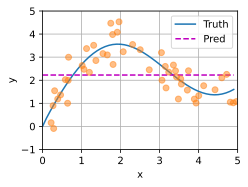

In [21]:
# 平均汇聚
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

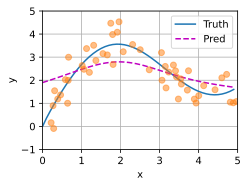

In [22]:
#非参数注意力汇聚

# X_repeat的形状:(n_test,n_train),
# 每一行都包含着相同的测试输入（例如：同样的查询）
X_repeat = x_test.repeat_interleave(n_train).reshape((-1,n_train))
# x_train包含着键。attention_weights的形状：(n_test,n_train),
# 每一行都包含着要在给定的每个查询的值（y_train）之间分配的注意力权重
attention_weights = nn.functional.softmax(-(X_repeat-x_train)**2/2, dim=1)
# y_hat的每个元素都是值的加权平均值，其中的权重是注意力权重
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

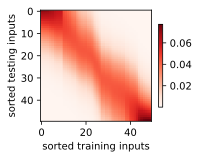

In [23]:
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='sorted training inputs',
                  ylabel='sorted testing inputs')

In [24]:
# 带参数注意力汇聚
X = torch.ones((2,1,4))
Y = torch.ones((2,4,6))
torch.bmm(X,Y).shape

torch.Size([2, 1, 6])

In [25]:
weights = torch.ones((2,10))*0.1
values = torch.arange(20.0).reshape((2,10))
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1)) # unsqueeze增加维度

tensor([[[ 4.5000]],

        [[14.5000]]])

In [26]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

    def forward(self, queries, keys, values):
        # # queries和attention_weights的形状为(查询个数，“键－值”对个数)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(-((queries-keys)*self.w)**2/2, dim=1)
        # values的形状为(查询个数，“键－值”对个数)
        return torch.bmm(self.attention_weights.unsqueeze(1), values.unsqueeze(-1)).reshape(-1)

In [27]:
# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1))
# Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))
# keys的形状:('n_train'，'n_train'-1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# values的形状:('n_train'，'n_train'-1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

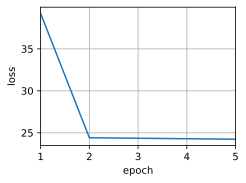

In [28]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

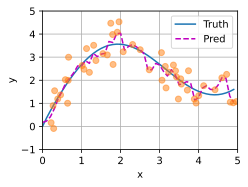

In [29]:
# keys的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
keys = x_train.repeat((n_test, 1))
# value的形状:(n_test，n_train)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

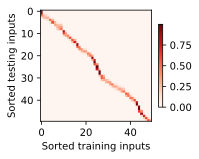

In [30]:
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')